In [ ]:
# install requirements
!pip install pinecone-client openai burr[graphviz] 

# Question & answer notebook

This notebook walks you through how to build a burr application that talks to pinecone and openai to answer questions about UFC fights.

In [2]:
# import what we need
import os
from typing import Tuple

import openai
from burr.core import ApplicationBuilder, State, default, expr, Application
from burr.core.action import action
from burr.tracking import LocalTrackingClient
import uuid
import pinecone

## Helper functions
We first set up some helper functions that we'll use.

In [1]:
def set_inital_chat_history() -> list[dict]:
    SYSTEM_MESSAGE = ("You're a helpful assistance, base your answer only on the provided context, "
                      "do not use preexisting knowledge.")

    messages = [{"role": "system", "content": SYSTEM_MESSAGE}]
    return messages


## Actions
Let's now define the actions that our application will make and what they read from & write to with respect to state.

In [3]:
@action(
    reads=[],
    writes=["question", "chat_history"],
)
def human_converse(state: State, user_question: str) -> Tuple[dict, State]:
    """Human converse step -- make sure we get input, and store it as state."""
    new_state = state.update(question=user_question)
    new_state = new_state.append(chat_history={"role": "user", "content": user_question})
    return {"question": user_question}, new_state


In [4]:
@action(
    reads=["question", "chat_history"],
    writes=["chat_history", "vector"],
)
def extract_embedding(state: State, client: openai.Client) -> tuple[dict, State]:
    """AI step to create the text embedding."""
    question = state["question"]
    # Create embeddings from user question
    response = client.embeddings.create(
        input=question,
        model="text-embedding-3-small"
    )
    vector = response.data[0].embedding
    new_state = state.update(vector=vector)
    return {"usage": response.usage.to_dict()}, new_state

In [5]:
@action(
    reads=["vector", "chat_history", "question"],
    writes=["vector", "chat_history"],
)
def query_vectordb(state: State, vector_db_index: pinecone.Index, top_k: int = 20) -> Tuple[dict, State]:
    """Query the vector DB to create the message context."""
    vector = state["vector"]
    response = vector_db_index.query(vector=vector,
                                     top_k=top_k,
                                     include_values=False,
                                     includeMetadata=True)
    matches = response['matches']
    context = []
    for match in matches:
        context.append(match['metadata'])
    content = f"Please use this context: {context}\n To answer the following question: {question}."
    new_state = state.append(chat_history={"role": "user", "content": content})
    new_state = new_state.update(vector=None)
    return {"num_results": len(response['matches'])}, new_state

In [6]:
@action(
    reads=["chat_history"],
    writes=["chat_history"],
)
def AI_generate_response(state: State, client: openai.Client) -> tuple[dict, State]:
    """AI step to generate the response."""
    messages = state["chat_history"]
    response = client.chat.completions.create(
        model="gpt-4-turbo-preview",
        messages=messages,
    )  # get a new response from the model where it can see the function response
    response_message = response.choices[0].message
    new_state = state.append(chat_history=response_message.to_dict())
    return {"ai_response": response_message.content,
            "usage": response.usage.to_dict()}, new_state

## Define the application
This is where we define our application now

In [11]:
# define our clients / connections / IDs
openai_client = openai.OpenAI()
db_client = pinecone.Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
index_name = "ufc"
index = db_client.Index(index_name)
application_run_id = str(uuid.uuid4())

In [12]:
# set the initial chat history
base_messages = set_inital_chat_history()

In [13]:
tracker = LocalTrackingClient("ufc-pinecone")
# create graph
burr_application = (
    ApplicationBuilder()
    .with_actions(  # define the actions
        extract_embedding.bind(client=openai_client),
        query_vectordb.bind(vector_db_index=index),
        AI_generate_response.bind(client=openai_client),
        human_converse
    )
    .with_transitions(  # define the edges between the actions based on state conditions
        ("human_converse", "extract_embedding", default),
        ("extract_embedding", "query_vectordb", default),
        ("query_vectordb", "AI_generate_response", default),
        ("AI_generate_response", "human_converse", default)
    )
    .with_identifiers(app_id=application_run_id)
    .with_state(  # initial state
        **{"chat_history": base_messages, "tool_calls": []},
    )
    .with_entrypoint("human_converse")
    .with_tracker(tracker)
    .build()
)

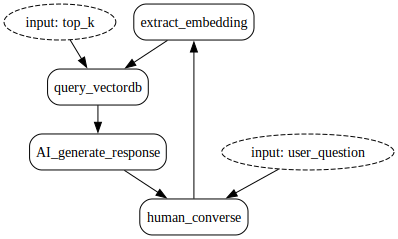

In [14]:
burr_application.visualize(include_conditions=True)

## Run the application
Here we show how to do a simple loop stopping before `human_converse` each time to get user input before running the graph again.


### Viewing a trace of the this application in the Burr UI
Note: you can view the logs of the conversation in the Burr UI. 

To see that, in another terminal do:

> burr

You'll then have the UI running on [http://localhost:7241/](http://localhost:7241/).

#### Using the Burr UI in google collab
To use the UI in google collab do the following:

1. Run this in a cell
```python
from google.colab import output
output.serve_kernel_port_as_window(7241)
```

2. Then start the burr UI:
```
!burr &
```
3. Click the link in (1) to open a new tab.

In [ ]:
# run it
while True:
    # this will ask for input:
    question = input("What can I help you with?\n")
    if question == "exit":
        break
    current_action, _, current_state = burr_application.run(
        halt_before=["human_converse"],
        inputs={"user_question": question},
    )
    # we'll then see the AI response:
    print(f"AI: {current_state['chat_history'][-1]['content']}\n")
current_state